# Estimating food flows with minimal data

This notebook illustrates a simplified method of estimating food flows between grid cells in the absence of detailed data. The basic idea is to balance calorie flows spatially, assuming that under normal conditions, supply meets or exceeds demand at national level, and all other things being equal, people will consume calories produced locally in preference to more distantly.

Input data required are as follows:
- Gridded population data
- Gridded "characteristic" annual production data by staple crops
- Calorie content per unit of production
- Calorie demands per capita

The methodology relies on the Iterative Proportional Fitting (IPF) technique, which is a way of adjusting an initial matrix such that its marginal sums match some target marginals. In this case, the initial matrix is a guess of the calorie flows between a collection of grid cells, e.g within a country. Each row and column is indexed by gridcell IDs. Each row can be thought of as the calorie flows **from** that row's gridcell to all other gridcells. Each column can be thought of as the flows **to** that column's gridcell from all other gridcells (the foodshed of the column gridcell). By adjusting the initial matrix according to the target marginals using IPF, we get a food flow matrix which is *consistent* with the target marginals, i.e. marginal sums over the fitted food flow matrix agree with the target marginals. See Wikipedia for more technical details  on IPF: https://en.wikipedia.org/wiki/Iterative_proportional_fitting.

The following assumptions need to be made:
- the calorific content of each kg of production, by staple crop
- the daily calorie demand per capita
- distance kernel function - uniform, exponential, squared exponential, ...

Limitations of this prototype:
- the principal limitation is that the problem is underdetermined - there are many possible food flow matrices that satisfy the marginal sum constraints
- the results from IPF are known to be sensitive to the initial matrix
- uses a static estimate of production
- assumes uniform consumption patterns across all ages and socioeconomic status
- considers only staple crops and uses flat calories/kg assumption for simplicity
- doesn't consider livestock
- doesn't consider imports/exports to/from the region being considered
- main determinant of the final estimate is the assumptions about the distance kernel, which determines the inital matrix
- distance kernel is "as the crow flies", i.e. doesn't account for physical or cultural boundaries
- distance kernel is uniform and isotropic - doesn't account for spatial variability or directional considerations
- ignores seasonality/seasonal variation of food flows as only annual production considered
- etc

Potential improvements:
- adjust for age and socioeconomic status when estimating marginal calorie demand vector
- be more precise in the calorific content of each crop
- account for seasonality using crop calendars and define monthly marginal calorie supply
- use travel time matrix instead of straight-line distance matrix - more realistic representation of how easy/cheap food is to transport
- account for national imports/exports

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Two custom packages which can be installed using pip
import quadgrid as qg
import pyipf

### 0. Demo of IPF on toy dataset

In [2]:
dims = (10, 10)

# Target matrix
M = np.random.lognormal(size=dims)

# Target marginals
m0 = M.sum(axis=0)
m1 = M.sum(axis=1)
marginals = [m0, m1]

# Perturb target matrix with random noise by scaling (initial matrix cannot be negative for IPF, so don't use additive noise)
M0 = M * np.exp(np.random.uniform(low=-3, high=3, size=dims))

Fit using IPF:

In [3]:
M1 = pyipf.ipf(M0, marginals)

In [4]:
print('Target marginal, axis 0:\n', m0)
print('Marginal of adjusted matrix, axis 0:\n', M1.sum(axis=0), '\n')
print('Target marginal, axis 1:\n', m1)
print('Marginal of adjusted matrix, axis 1:\n', M1.sum(axis=1))

Target marginal, axis 0:
 [17.21978819 11.74102177  8.11544182 16.00425612  9.92452068 20.95814049
 12.3997927   9.22878821 30.06067865 11.63511402]
Marginal of adjusted matrix, axis 0:
 [17.21950723 11.74126579  8.1154068  16.00431273  9.92452106 20.95667773
 12.40057975  9.22894806 30.06127599 11.63504753] 

Target marginal, axis 1:
 [21.24926959  9.33041401 16.29456898 13.2808556  15.35910247  8.4236049
 15.57015803 18.90923515 20.72168836  8.14864555]
Marginal of adjusted matrix, axis 1:
 [21.24926959  9.33041401 16.29456898 13.2808556  15.35910247  8.4236049
 15.57015803 18.90923515 20.72168836  8.14864555]


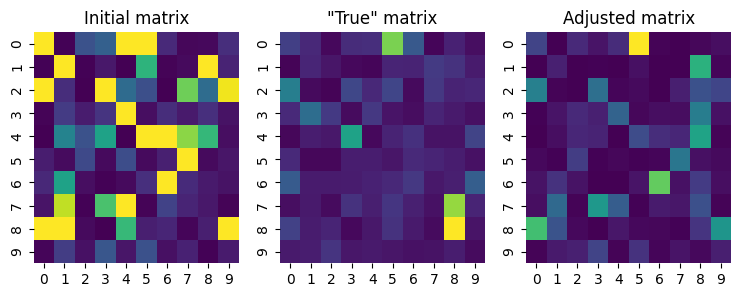

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,3))
vmin, vmax = 0, M.max()
sns.heatmap(M0, ax=ax1, vmin=vmin, vmax=vmax, cmap='viridis', cbar=False); ax1.set_title('Initial matrix')
sns.heatmap(M, ax=ax2, vmin=vmin, vmax=vmax, cmap='viridis', cbar=False); ax2.set_title('"True" matrix')
sns.heatmap(M1, ax=ax3, vmin=vmin, vmax=vmax, cmap='viridis', cbar=False); ax3.set_title('Adjusted matrix');

### 1. Food flow estimation

Load low-res country polygons for plotting and also approximate selection of gridcells by country:

In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world[world['continent']=='Africa']

/var/folders/_c/rp75w5gn0350fmjtsw645xqc0000gs/T/ipykernel_1199/4089673326.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Load pre-processed population and crop production data. The population data has been aggregated from high resolution WorldPop data for 2020 to 5' resolution (0.083 degreees). Crop production data has been processed from SPAM SSA 2017 crop masks and is already at 5' resolution.

In [7]:
pop = pd.read_parquet('data/africa_pop_5arcmin.parquet')
pop.head(2)

pop_total
lat        lon                  
-47.958333 -26.375000        NaN
           -26.291667        NaN

In [8]:
prod = pd.read_parquet('data/africa_cropprod_5arcmin.parquet')
prod.head(2)

staple
lat     lon               
-34.875 -25.458333     NaN
        -25.375000     NaN

Visualise total population and total staple production. Note that the maximum values of the colour bar scale have been limited to show some spatial detail in the plots.

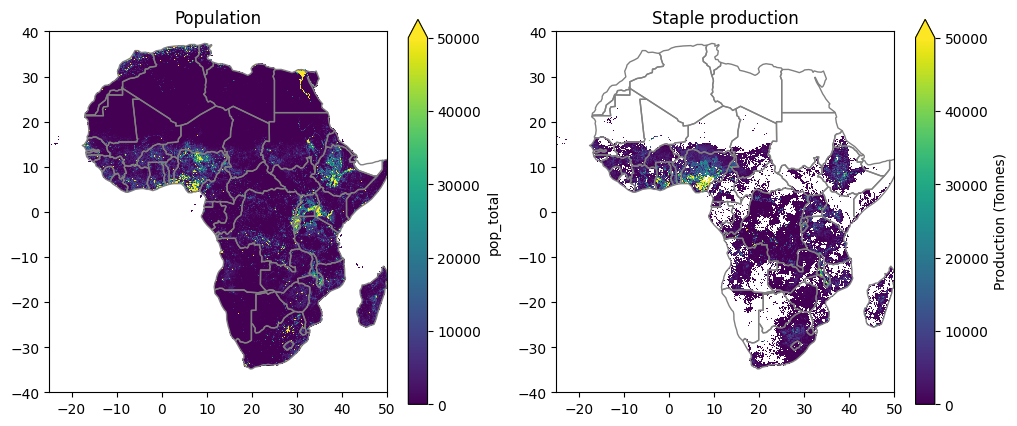

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
africa.boundary.plot(color='0.5', lw=1, ax=ax1); 
pop['pop_total'].to_xarray().plot(ax=ax1, cmap='viridis', vmax=5e4); 
ax1.set_title('Population'); ax1.set_xlabel(''); ax1.set_ylabel(''); ax1.set_xlim((-25,50)); ax1.set_ylim((-40,40));
africa.boundary.plot(color='0.5', lw=1, ax=ax2); 
prod['staple'].to_xarray().plot(ax=ax2, cmap='viridis', vmax=5e4, cbar_kwargs={'label': 'Production (Tonnes)'}); 
ax2.set_title('Staple production');  ax2.set_xlabel(''); ax2.set_ylabel(''); ax2.set_xlim((-25,50)); ax2.set_ylim((-40,40));

For comparison with the ground truth of survey-based data such as from Karg et al (2023), consider four countries: Mali, Cameroon, Burkina Faso, and Ghana. One way to facilitate the combination of population and production cells is to use a spatial index. In this case, use a uniform resolution quadtree grid, generate 5' quadcells over Africa, do a spatial join with each country in turn and use the resulting quadcell IDs (qids).

In [10]:
lon_bnds = africa.total_bounds[::2]
lat_bnds = africa.total_bounds[1::2]

In [11]:
urg = qg.QuadGrid(5/60, lon_bounds=lon_bnds, lat_bounds=lat_bnds)
urg_gdf = urg.to_geopandas()
urg_gdf.head(2)

,lat,lon,qid,res,area,mask,geometry
0,-34.791667,-17.625000,33791238,0.083333,70.513836,True,"POLYGON ((-17.58333 -34.75000, -17.58333 -34.8..."
1,-34.791667,-17.541667,33791239,0.083333,70.513836,True,"POLYGON ((-17.50000 -34.75000, -17.50000 -34.8..."


Country-specific URGs:

In [12]:
mli_urg_gdf = gpd.sjoin(urg_gdf, africa[africa['iso_a3']=='MLI'])
cmr_urg_gdf = gpd.sjoin(urg_gdf, africa[africa['iso_a3']=='CMR'])
bfa_urg_gdf = gpd.sjoin(urg_gdf, africa[africa['iso_a3']=='BFA'])
gha_urg_gdf = gpd.sjoin(urg_gdf, africa[africa['iso_a3']=='GHA'])
gha_urg_gdf.head(2)

,lat,lon,qid,res,area,mask,geometry,index_right,pop_est,continent,name,iso_a3,gdp_md_est
391710,4.708333,-2.125000,33550718,0.083333,85.573707,True,"POLYGON ((-2.08333 4.75000, -2.08333 4.66667, ...",59,30417856.0,Africa,Ghana,GHA,66983
391711,4.708333,-2.041667,33550719,0.083333,85.573707,True,"POLYGON ((-2.00000 4.75000, -2.00000 4.66667, ...",59,30417856.0,Africa,Ghana,GHA,66983


Next, calculate quadcell IDs for the indices of the population and production DataFrames:

In [13]:
pop_df = pop.reset_index()
pop_df['qid'] = qg.lls2qids(lons=pop_df['lon'], lats=pop_df['lat'], res_target=5/60)
pop_qid = pop_df.set_index('qid')['pop_total'].dropna()
pop_qid.head()

qid
56101470    0.0
56101471    0.0
56101450    0.0
56101451    0.0
56101454    0.0
Name: pop_total, dtype: float32

In [14]:
prod_df = prod.reset_index()
prod_df['qid'] = qg.lls2qids(lons=prod_df['lon'], lats=prod_df['lat'], res_target=5/60)
prod_qid = prod_df.set_index('qid')['staple'].dropna()
prod_qid.head()

qid
56020230     12.2
56020226      0.1
56020227     14.2
56020054    102.3
56020240    759.3
Name: staple, dtype: float64

Make a very simple conversion from population => annual calorie demand, and from annual production => annual calorie supply. In the first case, we simplistically assume 1800 calories per capita per day from staples. In the second case, we can use FAO food composition tables (https://www.fao.org/3/X9892E/X9892e05.htm) to estimate the calories per 100g of different staples. For simplicity, assume 340 cal/100g of staple (this could be refined by crop in a more detailed study), which equates to 3400 cal/kg, or 3400000 cal/tonne

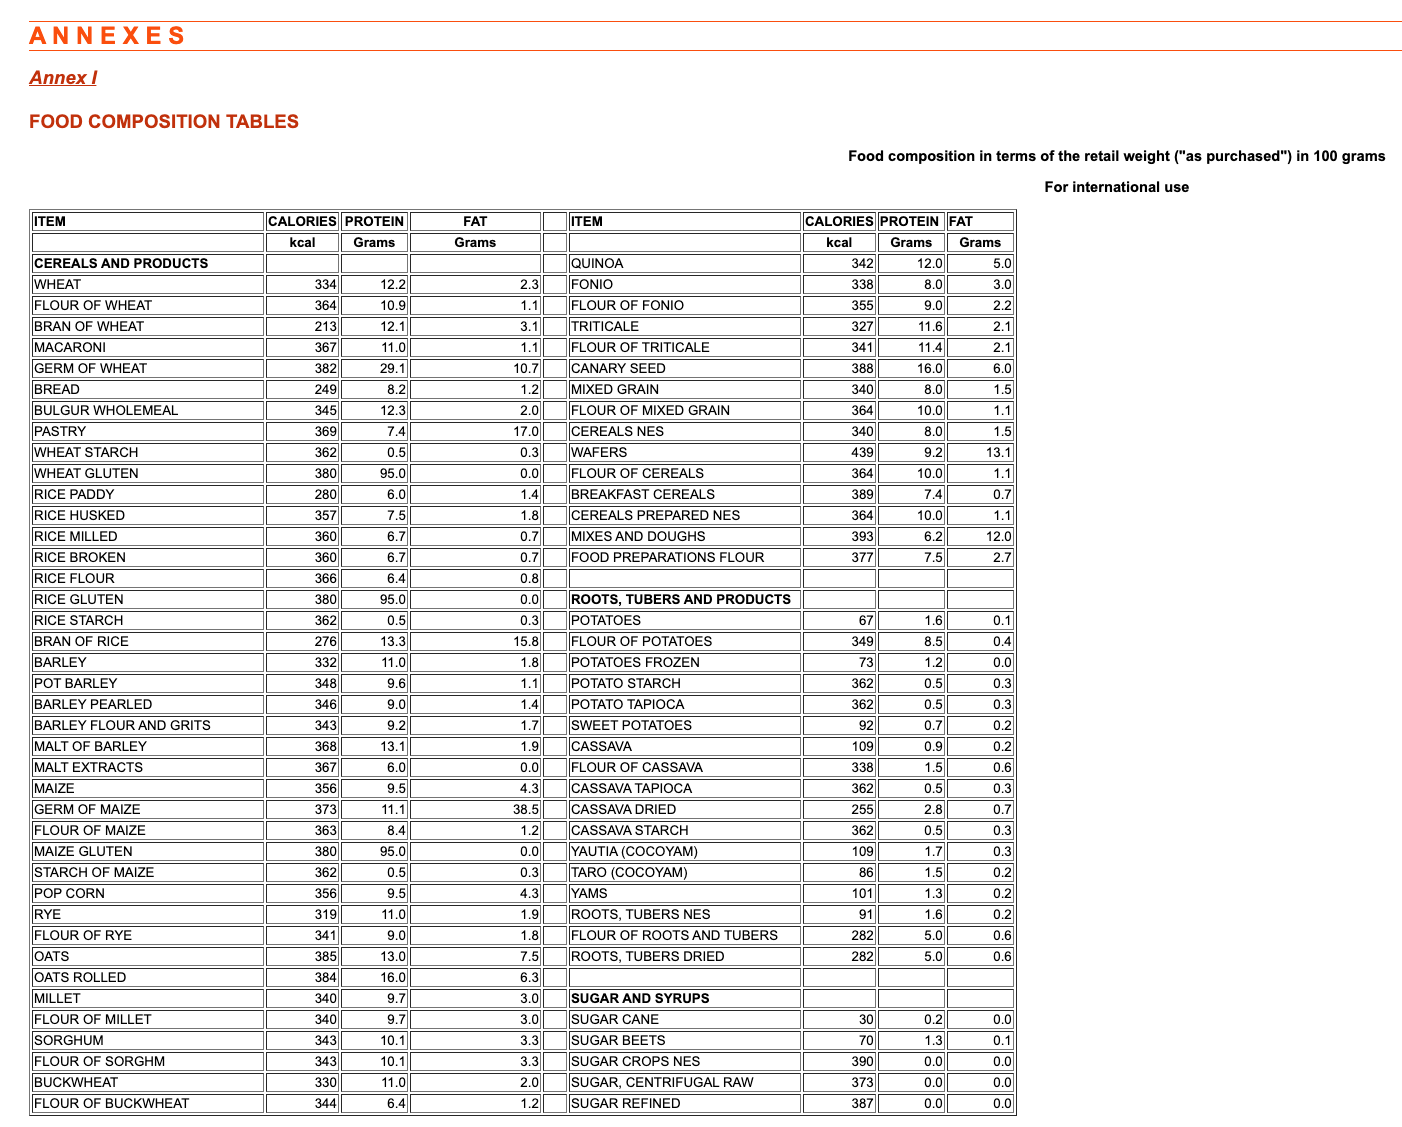

In [15]:
calorie_demand = pop_qid * 1800 * 365
calorie_supply = prod_qid * 3400 * 1000

For each country, select the relevant qids, and use them to select the relevant entries from the full continent demand and supply vectors:

In [16]:
mli_qids = mli_urg_gdf['qid'].to_numpy()
cmr_qids = cmr_urg_gdf['qid'].to_numpy()
bfa_qids = bfa_urg_gdf['qid'].to_numpy()
gha_qids = gha_urg_gdf['qid'].to_numpy()

In [17]:
mli_cal_demand = calorie_demand.reindex(mli_qids, fill_value=0)
mli_cal_supply = calorie_supply.reindex(mli_qids, fill_value=0)

cmr_cal_demand = calorie_demand.reindex(cmr_qids, fill_value=0)
cmr_cal_supply = calorie_supply.reindex(cmr_qids, fill_value=0)

bfa_cal_demand = calorie_demand.reindex(bfa_qids, fill_value=0)
bfa_cal_supply = calorie_supply.reindex(bfa_qids, fill_value=0)

gha_cal_demand = calorie_demand.reindex(gha_qids, fill_value=0)
gha_cal_supply = calorie_supply.reindex(gha_qids, fill_value=0)

One important point about the IPF method - the marginals must be consistent with each other. In the case of a 2D matrix with vector marginals, the total sums of each vector must be equal. Calculate the ratios between national supply and demand:

In [18]:
gha_cal_supply.sum()/mli_cal_demand.sum()

8.199864155284223

In [19]:
cmr_cal_supply.sum()/cmr_cal_demand.sum()

2.613487054854046

In [20]:
bfa_cal_supply.sum()/bfa_cal_demand.sum()

1.4567920803140308

In [21]:
gha_cal_supply.sum()/gha_cal_demand.sum()

5.445715046664613

It's reassuring that all countries produce more than they need! However we have mismatch between the marginal sums which must be corrected. There are different options:
- scale uniformly across all cells assuming that surplus production is exported or otherwise lost; this is the simplest method to implement. However, this seems unrealistic; the least productive cells are unlikely to export their production
- reduce the production of the largest producing cells by more than the least producing cells, assuming that only the most productive cells export their surplus; this seems more realistic, so do this. Even in this case, need to make some assumptions of how to do so. One simple way to do it is to reduce each cell's supply by its share of national production * national surplus.

First, calculate national surpluses:

In [22]:
mli_surplus = mli_cal_supply.sum() - mli_cal_demand.sum()
cmr_surplus = cmr_cal_supply.sum() - cmr_cal_demand.sum()
bfa_surplus = bfa_cal_supply.sum() - bfa_cal_demand.sum()
gha_surplus = gha_cal_supply.sum() - gha_cal_demand.sum()

Then, reduce each gridcell's supply by a proportion of the national surplus, where the proportions are calculated as each gridcell's share of national production. This means that the most productive gridcells are reduced the most, and the least productive gridcells are reduced the least.

In [23]:
mli_cal_supply_adj =  mli_cal_supply - mli_cal_supply/mli_cal_supply.sum() * mli_surplus
cmr_cal_supply_adj =  cmr_cal_supply - cmr_cal_supply/cmr_cal_supply.sum() * cmr_surplus
bfa_cal_supply_adj =  bfa_cal_supply - bfa_cal_supply/bfa_cal_supply.sum() * bfa_surplus
gha_cal_supply_adj =  gha_cal_supply - gha_cal_supply/gha_cal_supply.sum() * gha_surplus

Compare grid level supply, adjusted supply and demand:

In [24]:
mli_cal_supply_sorted = mli_cal_supply.sort_values()
cmr_cal_supply_sorted = cmr_cal_supply.sort_values()
bfa_cal_supply_sorted = bfa_cal_supply.sort_values()
gha_cal_supply_sorted = gha_cal_supply.sort_values()

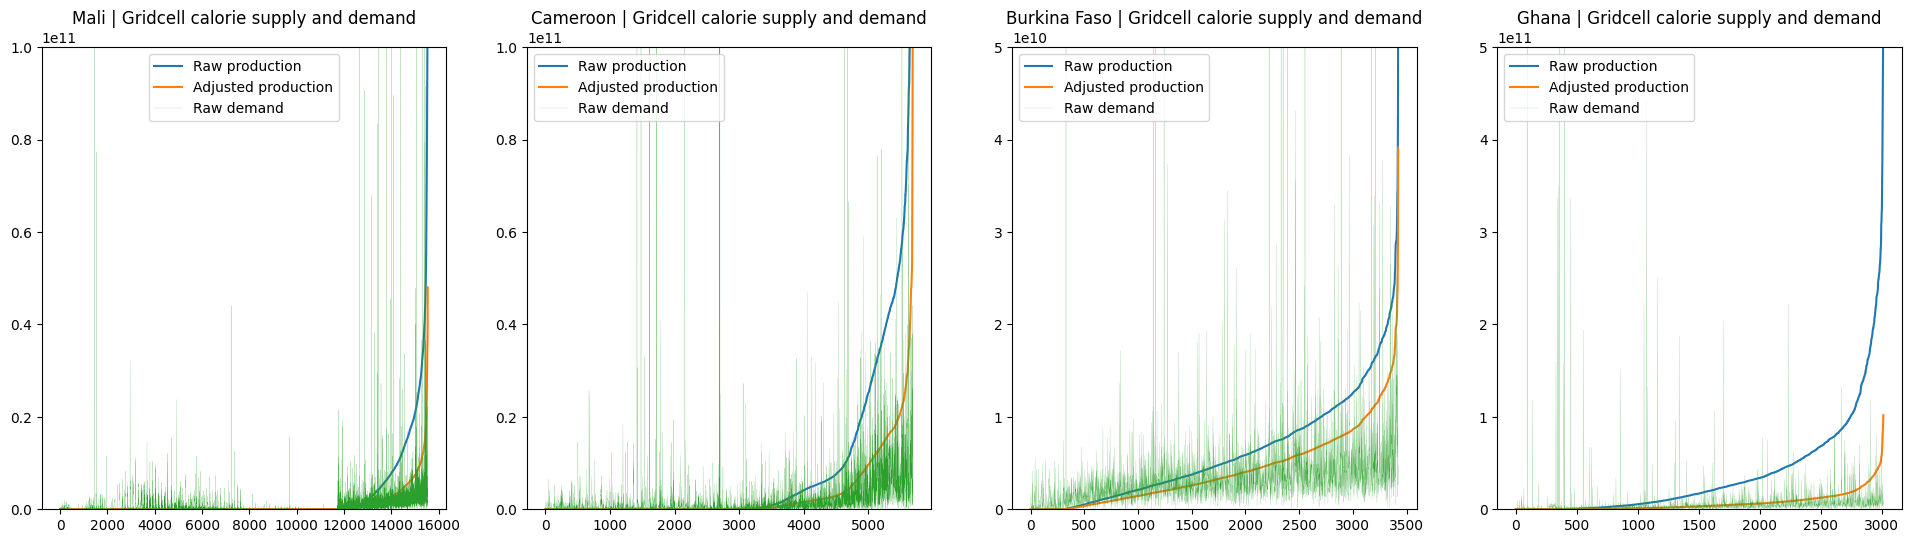

In [25]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24,6))
ax1.plot(mli_cal_supply_sorted.values, label='Raw production')
ax1.plot(mli_cal_supply_adj.reindex(mli_cal_supply_sorted.index).values, label='Adjusted production')
ax1.plot(mli_cal_demand.reindex(mli_cal_supply_sorted.index).values, label='Raw demand', lw=0.1)
ax1.set_title('Mali | Gridcell calorie supply and demand'); ax1.legend(); ax1.set_ylim((-1e6,1e11));

ax2.plot(cmr_cal_supply_sorted.values, label='Raw production')
ax2.plot(cmr_cal_supply_adj.reindex(cmr_cal_supply_sorted.index).values, label='Adjusted production')
ax2.plot(cmr_cal_demand.reindex(cmr_cal_supply_sorted.index).values, label='Raw demand', lw=0.1)
ax2.set_title('Cameroon | Gridcell calorie supply and demand'); ax2.legend(); ax2.set_ylim((-1e6,1e11));

ax3.plot(bfa_cal_supply_sorted.values, label='Raw production')
ax3.plot(bfa_cal_supply_adj.reindex(bfa_cal_supply_sorted.index).values, label='Adjusted production')
ax3.plot(bfa_cal_demand.reindex(bfa_cal_supply_sorted.index).values, label='Raw demand', lw=0.1)
ax3.set_title('Burkina Faso | Gridcell calorie supply and demand'); ax3.legend(); ax3.set_ylim((-1e3,5e10));

ax4.plot(gha_cal_supply_sorted.values, label='Raw production')
ax4.plot(gha_cal_supply_adj.reindex(gha_cal_supply_sorted.index).values, label='Adjusted production')
ax4.plot(gha_cal_demand.reindex(gha_cal_supply_sorted.index).values, label='Raw demand', lw=0.1)
ax4.set_title('Ghana | Gridcell calorie supply and demand'); ax4.legend(); ax4.set_ylim((-1e3,5e11));

Having calculated adjusted supply and demand for each country, we now have the marginal vectors for the IPF procedure. All that remains is to generate the initial matrices. We start by calculating distance matrices for all qids within each country:

In [26]:
mli_dmat = pd.DataFrame(qg.distance.dmat(lons1=mli_urg_gdf['lon'].to_numpy(), lats1=mli_urg_gdf['lat'].to_numpy(), 
                                         lons2=mli_urg_gdf['lon'].to_numpy(), lats2=mli_urg_gdf['lat'].to_numpy()), index=mli_urg_gdf['qid'], columns=mli_urg_gdf['qid'])
cmr_dmat = pd.DataFrame(qg.distance.dmat(lons1=cmr_urg_gdf['lon'].to_numpy(), lats1=cmr_urg_gdf['lat'].to_numpy(), 
                                         lons2=cmr_urg_gdf['lon'].to_numpy(), lats2=cmr_urg_gdf['lat'].to_numpy()), index=cmr_urg_gdf['qid'], columns=cmr_urg_gdf['qid'])
bfa_dmat = pd.DataFrame(qg.distance.dmat(lons1=bfa_urg_gdf['lon'].to_numpy(), lats1=bfa_urg_gdf['lat'].to_numpy(), 
                                         lons2=bfa_urg_gdf['lon'].to_numpy(), lats2=bfa_urg_gdf['lat'].to_numpy()), index=bfa_urg_gdf['qid'], columns=bfa_urg_gdf['qid'])
gha_dmat = pd.DataFrame(qg.distance.dmat(lons1=gha_urg_gdf['lon'].to_numpy(), lats1=gha_urg_gdf['lat'].to_numpy(), 
                                         lons2=gha_urg_gdf['lon'].to_numpy(), lats2=gha_urg_gdf['lat'].to_numpy()), index=gha_urg_gdf['qid'], columns=gha_urg_gdf['qid'])

The distance matrices are the starting point for estimating the initial flow matrix, but need to choose a functional form for the kernel. We expect flows to be greater the closer two cells are, all else being equal. The simplest kernel is a linear decay with distance. However, we could also use a negative exponential or a negative squared exponential (Gaussian) kernel. There is also the choice of the scaling factor for each kernel, which controls the rate of a kernel's decay. For this example assume a 100km scaling constant with a Gaussian kernel. 

In [27]:
M0_mli = np.exp(-(mli_dmat/100)**2)
M0_cmr = np.exp(-(cmr_dmat/100)**2)
M0_bfa = np.exp(-(bfa_dmat/100)**2)
M0_gha = np.exp(-(gha_dmat/100)**2)

Visualise kernel in 1D for a single gridcell in Mali - since kernels above are all identical, the country/gridcell plotted doesn't matter:

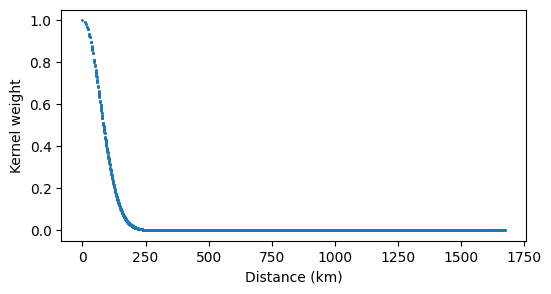

In [28]:
fig, ax = plt.subplots(1,1, figsize=(6,3))
ax.scatter(mli_dmat[33542521], M0_mli[33542521], s=1)
ax.set_xlabel('Distance (km)'); ax.set_ylabel('Kernel weight');

Define lat, lon pandas MultiIndex from qids - this makes it easy to quickly convert a pandas Series to an xarray DataArray for easy spatial plotting:

In [29]:
lons_mli, lats_mli = qg.qids2lls(M0_mli.index, res_target=5/60)
mix_mli = pd.MultiIndex.from_arrays([lats_mli, lons_mli], names=['lat','lon'])

lons_cmr, lats_cmr = qg.qids2lls(M0_cmr.index, res_target=5/60)
mix_cmr = pd.MultiIndex.from_arrays([lats_cmr, lons_cmr], names=['lat','lon'])

lons_bfa, lats_bfa = qg.qids2lls(M0_bfa.index, res_target=5/60)
mix_bfa = pd.MultiIndex.from_arrays([lats_bfa, lons_bfa], names=['lat','lon'])

lons_gha, lats_gha = qg.qids2lls(M0_gha.index, res_target=5/60)
mix_gha = pd.MultiIndex.from_arrays([lats_gha, lons_gha], names=['lat','lon'])

Do the IPF procedure for each country. Note that we add a small number (1e-6) to all the marginal vectors - this prevents any of them from being zero which breaks the IPF method.

In [30]:
mli_foodflow = pd.DataFrame(pyipf.ipf(M0_mli.to_numpy(), marginals=[mli_cal_supply_adj.to_numpy()+1e-6, mli_cal_demand.to_numpy()+1e-6], pbar=True), index=mix_mli, columns=M0_mli.columns)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [31]:
cmr_foodflow = pd.DataFrame(pyipf.ipf(M0_cmr.to_numpy(), marginals=[cmr_cal_supply_adj.to_numpy()+1e-6, cmr_cal_demand.to_numpy()+1e-6], pbar=True), index=mix_cmr, columns=M0_cmr.columns)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [32]:
bfa_foodflow = pd.DataFrame(pyipf.ipf(M0_bfa.to_numpy(), marginals=[bfa_cal_supply_adj.to_numpy()+1e-6, bfa_cal_demand.to_numpy()+1e-6], pbar=True), index=mix_bfa, columns=M0_bfa.columns)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
gha_foodflow = pd.DataFrame(pyipf.ipf(M0_gha.to_numpy(), marginals=[gha_cal_supply_adj.to_numpy()+1e-6, gha_cal_demand.to_numpy()+1e-6], pbar=True), index=mix_gha, columns=M0_gha.columns)

  0%|          | 0/1000 [00:00<?, ?it/s]

Calculate 5' qids associated with each of the locations in Karg et al (2023); use Google Maps to extract the lat, lon and convert to qid:

In [34]:
bamako_lat, bamako_lon = 12.615258813872794, -7.989679128182463
bamako_qid = qg.ll2qid(bamako_lon, bamako_lat, res_target=5/60)
bamenda_lat, bamenda_lon = 5.964686149611336, 10.156915021343385
bamenda_qid = qg.ll2qid(bamenda_lon, bamenda_lat, res_target=5/60)
ouagadougou_lat, ouagadougou_lon = 12.375759789999865, -1.526372594626114
ouagadougou_qid = qg.ll2qid(ouagadougou_lon, ouagadougou_lat, res_target=5/60)
tamale_lat, tamale_lon = 9.413959656366126, -0.8447527885732815
tamale_qid = qg.ll2qid(tamale_lon, tamale_lat, res_target=5/60)

Visualise, with adjustments to the upper bound of the colour bar, to stop details from lower production gridcells being lost:

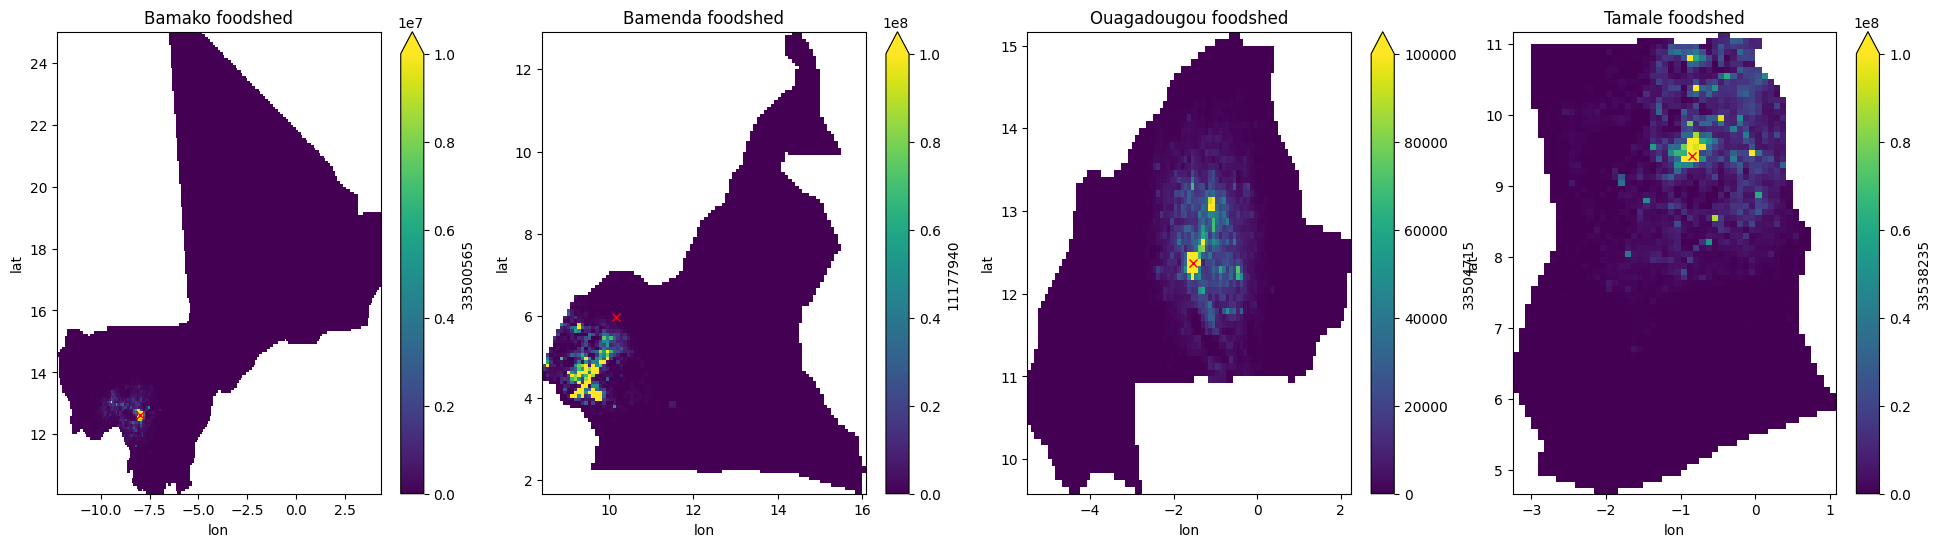

In [35]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24,6))
mli_foodflow[bamako_qid].to_xarray().plot(ax=ax1, vmax=1e7); ax1.plot([bamako_lon], [bamako_lat], marker='x', color='r'); ax1.set_title('Bamako foodshed')
cmr_foodflow[bamenda_qid].to_xarray().plot(ax=ax2, vmax=1e8); ax2.plot([bamenda_lon], [bamenda_lat], marker='x', color='r'); ax2.set_title('Bamenda foodshed')
bfa_foodflow[ouagadougou_qid].to_xarray().plot(ax=ax3, vmax=1e5); ax3.plot([ouagadougou_lon], [ouagadougou_lat], marker='x', color='r'); ax3.set_title('Ouagadougou foodshed')
gha_foodflow[tamale_qid].to_xarray().plot(ax=ax4, vmax=1e8); ax4.plot([tamale_lon], [tamale_lat], marker='x', color='r'); ax4.set_title('Tamale foodshed');